This post contains my work in predicting whether a patient has diabetes or not based on various diagnostic metrics. The patients studied are females of Pima Indian heritage and at least 21 years old. 

Through my work, I was able to predict diabetes at an accuracy of approximately 80%.

The dataset is provided by the National Institute of Diabetes and Digestive and Kidney Diseases. For more information and to download the dataset, the following link can be accessed https://www.kaggle.com/uciml/pima-indians-diabetes-database. To download my jupyter notebook, the following link can be accessed https://github.com/JayaPok/Pima-Indians-Diabetes.

In [1023]:
#import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Read Data

In [704]:
diabetes_data = pd.read_csv("pima-indians-diabetes-database/diabetes.csv")
diabetes_data = diabetes_data.astype(float)

### Create training and test set

Creating a test set that will only be used to test models built. The test set will not be examined prior to this.

In [1024]:
# Create training and test data
from sklearn.model_selection import train_test_split

X_train_init, X_test_init = train_test_split(diabetes_data, test_size = 0.2, random_state = 1)

### Exploratory Data Analysis

The tables below help get an initial view of the training data and the diagnostic measurements we're working with. From this we can see that there are metrics which are all floats. In addition, although it appears as though there are no null values, the null values for a few of the metrics are most likely replaced with 0. This is because the second table shows the minimum values for Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI to be 0 which isn't possible.

In [933]:
# View of Data
X_train_init.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
663,9.0,145.0,80.0,46.0,130.0,37.9,0.637,40.0,1.0
712,10.0,129.0,62.0,36.0,0.0,41.2,0.441,38.0,1.0
161,7.0,102.0,74.0,40.0,105.0,37.2,0.204,45.0,0.0
509,8.0,120.0,78.0,0.0,0.0,25.0,0.409,64.0,0.0
305,2.0,120.0,76.0,37.0,105.0,39.7,0.215,29.0,0.0


In [934]:
# Column Stats
X_train_init.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.866450,121.257329,68.861564,19.820847,79.035831,31.832410,0.463795,33.298046,0.346906
std,3.387687,31.660602,19.738636,15.859718,116.585553,7.630488,0.327362,11.810249,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.000000,0.244250,24.000000,0.000000
50%,3.000000,117.000000,72.000000,22.000000,16.500000,31.950000,0.361500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,125.000000,36.375000,0.596500,41.000000,1.000000
max,15.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.329000,72.000000,1.000000


In [935]:
# Look for Null Values
X_train_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 663 to 37
Data columns (total 9 columns):
Pregnancies                 614 non-null float64
Glucose                     614 non-null float64
BloodPressure               614 non-null float64
SkinThickness               614 non-null float64
Insulin                     614 non-null float64
BMI                         614 non-null float64
DiabetesPedigreeFunction    614 non-null float64
Age                         614 non-null float64
Outcome                     614 non-null float64
dtypes: float64(9)
memory usage: 48.0 KB


The histograms below show the distributions of each of the metrics. The Outcomes histogram shows that there is approximately twice as many patients without diabetes than with diabetes in the training data. The spikes at 0 for Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI support that nulls for these metrics are replaced with 0.

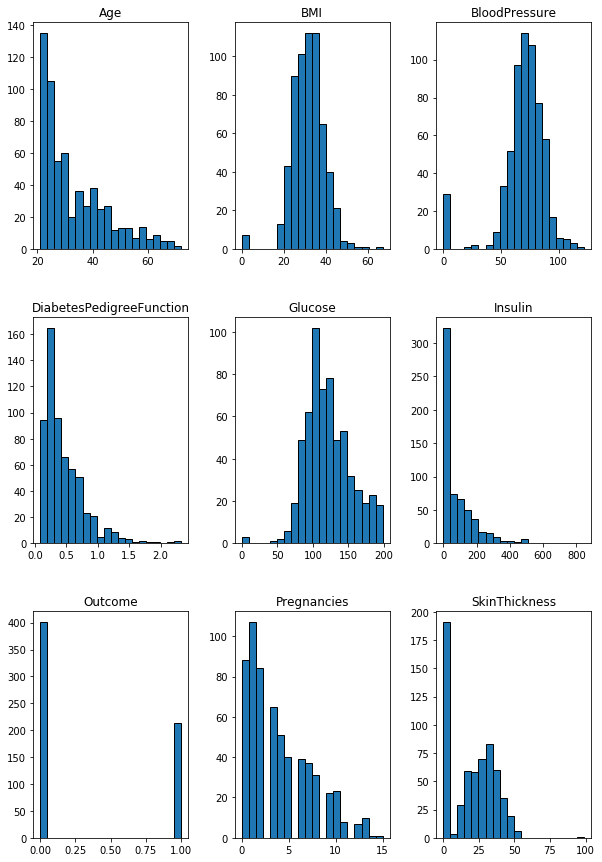

In [940]:
# Histograms
X_train_init.hist(figsize=(10, 15), edgecolor = 'black', grid = False, bins = 20)
plt.show()

Constructing pair plots for each pair of features and for each outcome (diabetes or no diabetes) is a good technique for visualizing the training data as can be seen below. Although there is no pair of features that indicates a clear difference between patients with and without diabetes, we can start to see some of what the most useful metrics may be. 

Looking at the distributions along the diagonal, Age and Glucose stand out as the features with the greatest difference in distribution by outcome. Looking further at the pair plots, metrics with BMI or Glucose as one of the axes seem to indicate notable differences by outcome. 

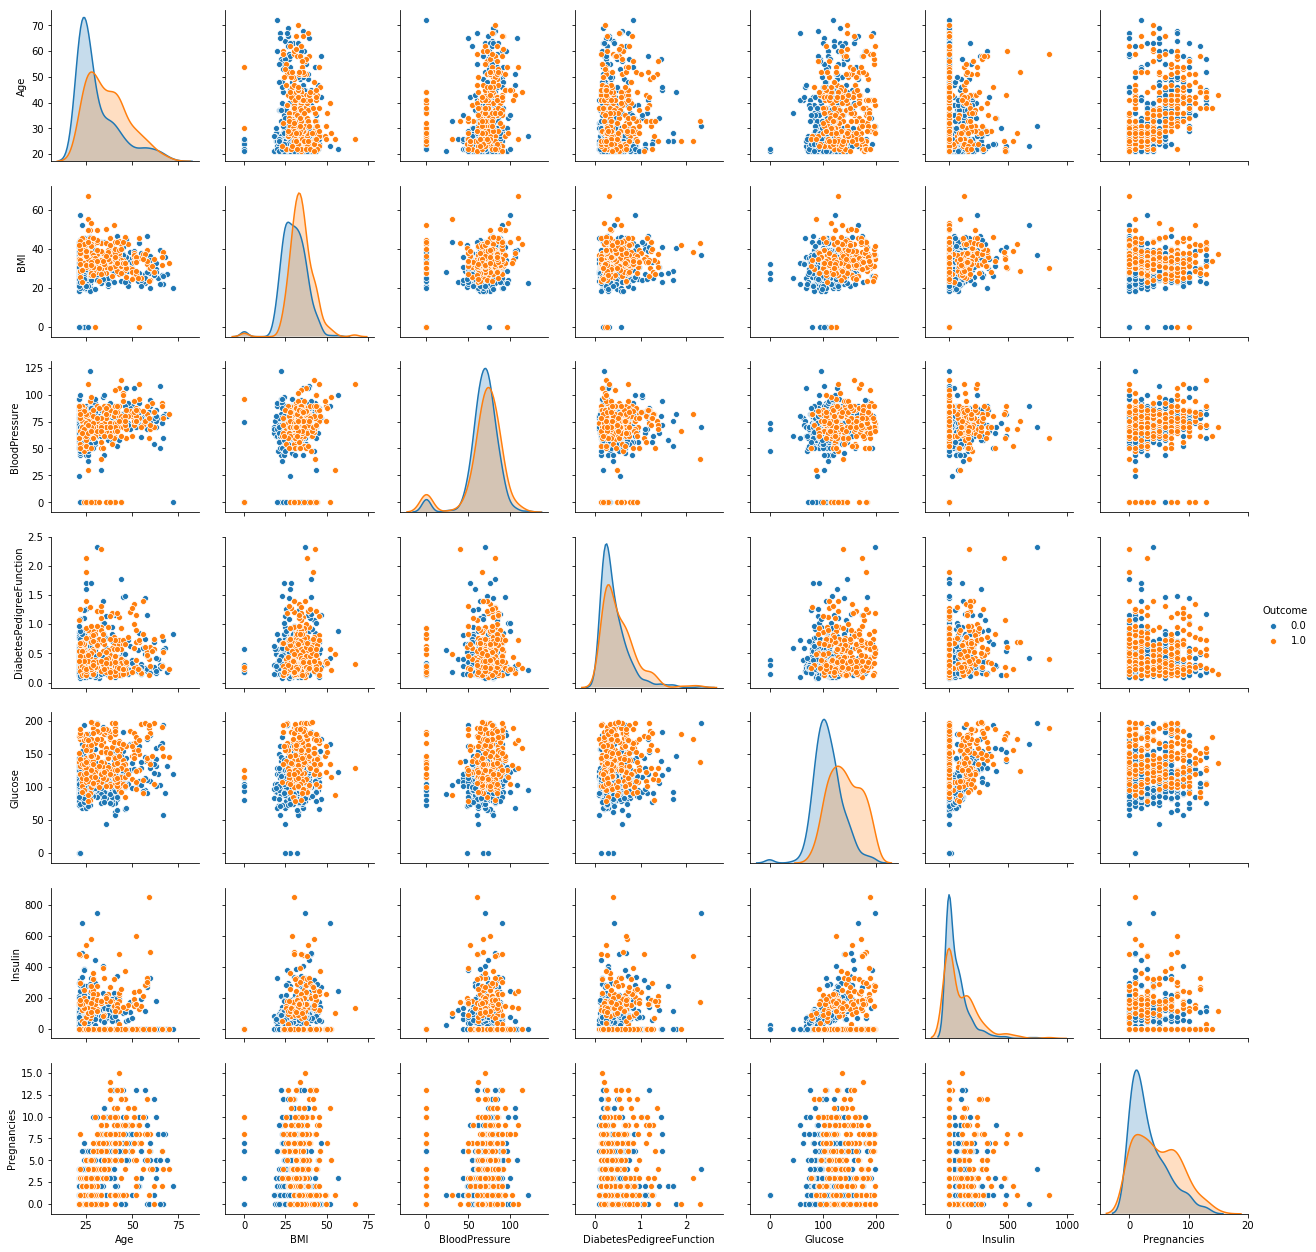

In [941]:
# Pair Plots 
X_train_init_noNA = X_train_init.dropna()

sns.pairplot(X_train_init_noNA, hue = 'Outcome', vars = ['Age', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', \
                                                    'Glucose', 'Insulin', 'Pregnancies'], dropna = True)
plt.show()

Constructing a correlation matrix is a good technique of visualizing the relationship between variables to check for multicollinearity. As seen below, none of the variables are highly correlated with each other so we won't remove any of them.

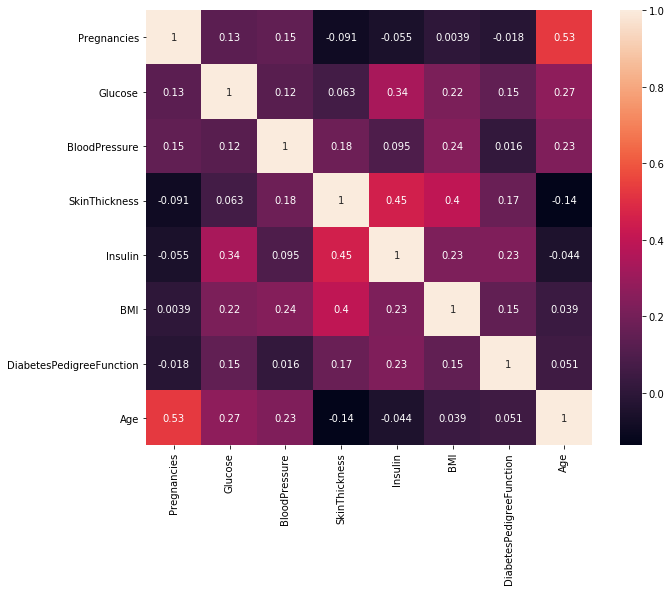

In [942]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_init[X_train_init.columns[:8]].corr(), annot=True)
plt.show()

### Basic Model Implementation

Initially we can try implementing a few models without doing any feature engineering or selection just to see what accuracy we get. Since we want to minimize the number of times we use the test set, 5-fold cross validation is performed to judge the accuracy of each model

In [1025]:
# Separate outcomes from features
y_train = X_train_init.Outcome
X_train = X_train_init.drop("Outcome", axis = 1)

y_test = X_test_init.Outcome
X_test = X_test_init.drop("Outcome", axis = 1)

In [1026]:
# Try Different Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


models = [LogisticRegression(solver = 'liblinear'), GaussianNB(), \
          RandomForestClassifier(n_estimators = 100, max_depth = 5), \
          ExtraTreesClassifier(n_estimators = 100, max_depth = 5), XGBClassifier()]

model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Extra Trees', 'XGBoost']

k_folds = 5

In [945]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.765487568413
Naive Bayes :  0.749253201945
Random Forest :  0.758956632401
Extra Trees :  0.73945690541
XGBoost :  0.737778222045


From performing cross validation with each model, we can see that logistic regression performed the best so we will use a logistic model on the test set.

In [946]:
from sklearn import metrics

print("Test Set:")
predictions = LogisticRegression(solver = 'liblinear').fit(X_train, y_train).predict(X_test)
print("Accuracy: ", round(metrics.accuracy_score(y_test, predictions) * 100, 1), "%")

Test Set:
Accuracy:  77.9 %


Approximately 78% accuracy from a very basic model implementation, not bad! But let's see if we can do better.

### Impute Missing Values

The first step we want to take is to impute the null values for Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI. The method chosen to do this is to replace null values with the median value of the outcome the respective patient is most likely to have. 

In [949]:
X_train_init_null = X_train_init.copy()
X_test_init_null = X_test_init.copy()

X_train_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
    X_train_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)
    
X_test_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
    X_test_init_null[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

As seen below, the median values of the metrics for patients with diabetes are all higher than for patients without diabetes, so we want to try to avoid imputing missing values with overall medians.

In [1027]:
# Impute missing values
diabetes_median = X_train_init_null[X_train_init_null.Outcome == 1]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()
    

no_diabetes_median = X_train_init_null[X_train_init_null.Outcome == 0]\
    [['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].median()
    
    
print("Median of People with Diabetes:")
print(diabetes_median, '\n')


print("Median of People without Diabetes:")
print(no_diabetes_median, '\n')

    
print("Difference Between Medians of People with and without Diabetes:")
print(diabetes_median - no_diabetes_median, '\n')


diabetes_median_array = np.array(diabetes_median)
no_diabetes_median_array = np.array(no_diabetes_median)

Median of People with Diabetes:
Glucose          140.0
BloodPressure     74.0
SkinThickness     32.0
Insulin          175.0
BMI               34.3
dtype: float64 

Median of People without Diabetes:
Glucose          107.0
BloodPressure     70.0
SkinThickness     27.0
Insulin           95.0
BMI               30.1
dtype: float64 

Difference Between Medians of People with and without Diabetes:
Glucose          33.0
BloodPressure     4.0
SkinThickness     5.0
Insulin          80.0
BMI               4.2
dtype: float64 



The function below acts to identify whether a patient is most likely to have diabetes or not by looking at differences of metrics with the two sets of medians calculated above and then replacing null values with the most likely median. Since this technique doesn't use Outcome in the imputation, there will be some error of imputation in the training set. However, we will consequently be able to use this technique for imputation of the test set.

In [952]:
X_train_null = X_train_init_null.drop("Outcome", axis = 1)
X_test_null = X_test_init_null.drop("Outcome", axis = 1)

In [1028]:
def impute_nan(input_row):
    input_row_short = input_row[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]
    missing_indexes = np.argwhere(np.isnan(input_row_short))

    row_no_nan = np.array([i for j, i in enumerate(input_row_short) if j not in missing_indexes])
    diabetes_median_no_nan = np.array([i for j, i in enumerate(diabetes_median_array) if j not in missing_indexes])
    no_diabetes_median_no_nan = np.array([i for j, i in enumerate(no_diabetes_median_array) if j not in missing_indexes])
    
    euclidean_diabetes = np.linalg.norm(row_no_nan - diabetes_median_no_nan)
    euclidean_no_diabetes = np.linalg.norm(row_no_nan - no_diabetes_median_no_nan)
    
    min_dist = min(euclidean_diabetes, euclidean_no_diabetes)
    
    if min_dist == euclidean_diabetes:
        for val in missing_indexes:
            input_row_short[val] = diabetes_median_array[val[0]]
    else:
        for val in missing_indexes:
            input_row_short[val] = no_diabetes_median_array[val[0]]
            
    input_row[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = input_row_short
            
    return input_row

In [956]:
X_train_imputed = X_train_null.copy()
X_test_imputed = X_test_null.copy()

X_train_imputed = X_train_imputed.apply(impute_nan, axis = 1)
X_test_imputed = X_test_imputed.apply(impute_nan, axis = 1)

When performing cross validation on the imputed training set, we see minimal differences in accuracy than what we saw before imputation. However, the imputation will help with some of our next steps.

In [957]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train_imputed, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.752491906463
Naive Bayes :  0.74273602387
Random Forest :  0.752412583354
Extra Trees :  0.752425911356
XGBoost :  0.750773454059


### New Features

On this step we will add features which may contribute to the accuracy of the models. First, categorical variables were added pertaining to Obesity, Hypertension, Glucose Tolerance. Next, polynomial variables were added for a few of the metrics. Finally, interaction variables were added using a few of the metrics.  

In [971]:
X_train_addedColumns = X_train_imputed.copy()
X_test_addedColumns = X_test_imputed.copy()

In [1029]:
### Add new features
def add_features(initial_df):  
    # Obesity
    initial_df.loc[:,'Obesity'] = 'None'
    initial_df.loc[(initial_df['BMI'] <= 18.5), 'Obesity'] = 'Underweight'
    initial_df.loc[(initial_df['BMI'] >= 18.5) & \
                             (initial_df['BMI'] < 25), 'Obesity'] = 'Normal'
    initial_df.loc[(initial_df['BMI'] >= 25) & \
                             (initial_df['BMI'] < 30), 'Obesity'] = 'Overweight'
    initial_df.loc[(initial_df['BMI'] >= 30), 'Obesity'] = 'Obese'

    # Hypertension
    initial_df.loc[:, 'Hypertension'] = 'None'
    initial_df.loc[(initial_df['BloodPressure'] < 80), 'Hypertension'] = 'Normal or Elevated'
    initial_df.loc[(initial_df['BloodPressure'] >= 80) & \
                             (initial_df['BloodPressure'] < 90), 'Hypertension'] = 'Hypertension Stage 1'
    initial_df.loc[(initial_df['BloodPressure'] >= 90), 'Hypertension'] = 'Hypertension Stage 2'

    # OGTT test
    initial_df.loc[:, 'OGTT'] = 'None'
    initial_df.loc[(initial_df['Glucose'] < 140), 'OGTT'] = 'Normal'
    initial_df.loc[(initial_df['Glucose'] >= 140) & \
                             (initial_df['Glucose'] < 200), 'OGTT'] = 'Pre-Diabetes'
    initial_df.loc[(initial_df['Glucose'] >= 200), 'OGTT'] = 'Diabetes'

    # Polynomials
    initial_df['Glucose_squared'] = initial_df['Glucose'] ** 2
    initial_df['Glucose_cubed'] = initial_df['Glucose'] ** 3

    initial_df['BMI_squared'] = initial_df['BMI'] ** 2
    initial_df['BMI_cubed'] = initial_df['BMI'] ** 3

    initial_df['Age_squared'] = initial_df['Age'] ** 2
    initial_df['Age_cubed'] = initial_df['Age'] ** 3
    
    initial_df['DiabetesPedigreeFunction_squared'] = initial_df['DiabetesPedigreeFunction'] ** 2
    initial_df['DiabetesPedigreeFunction_cubed'] = initial_df['DiabetesPedigreeFunction'] ** 3

    # Interactions
    initial_df['Pregnancies_x_Age'] = initial_df['Pregnancies'] * initial_df['Age']
    initial_df['BP_x_Age'] = initial_df['BloodPressure'] * initial_df['Age']
    initial_df['BP_x_Glucose'] = initial_df['BloodPressure'] * initial_df['Glucose']
    initial_df['DPF_x_Glucose'] = initial_df['DiabetesPedigreeFunction'] * initial_df['Glucose']
    initial_df['BMI_x_Age'] = initial_df['BMI'] * initial_df['Age']
    initial_df['BP_x_DPF'] = initial_df['BloodPressure'] * initial_df['DiabetesPedigreeFunction']
    initial_df['Pregnancies_x_Glucose'] = initial_df['Pregnancies'] * initial_df['Glucose']
    
    return initial_df
    
X_train_addedColumns = add_features(X_train_addedColumns)
X_test_addedColumns = add_features(X_test_addedColumns)

Next we will standardize the numerical variables to avoid unequal contributions by variables of different scales. Also one hot encoding is used on the categorial variables to enable usage of the models. 

In [976]:
# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']] = \
    scaler.fit_transform(X_train_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']])
    
X_test_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']] = \
    scaler.fit_transform(X_test_addedColumns[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', \
                    'DiabetesPedigreeFunction', 'Age', 'Glucose_squared', 'Glucose_cubed', 'BMI_squared', \
                    'BMI_cubed', 'DiabetesPedigreeFunction_squared', 'DiabetesPedigreeFunction_cubed', \
                    'Pregnancies_x_Age', 'BP_x_Glucose', 'DPF_x_Glucose', 'BMI_x_Age']])

In [975]:
# Encoding
X_train_encoded = pd.get_dummies(X_train_addedColumns)
X_test_encoded = pd.get_dummies(X_test_addedColumns)

When performing cross validation on the training set with all the additional columns, we once again see minimal differences from before. However, the new features will be useful during feature selection.

In [964]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train_encoded, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.763795342078
Naive Bayes :  0.706843069224
Random Forest :  0.755664400906
Extra Trees :  0.755624846835
XGBoost :  0.74912121173


### Feature Selection

Performing feature selection will improve our models by removing features that don't contribute as much to predictions and by reducing overfitting. One method to perform feature selection is calulating F scores from the XGBoost classifier. The F scores provide a value of the relative importance of each feature where a higher F score corresponds to higher importance.

In [978]:
# Feature Importance
from xgboost import plot_importance
import eli5
from eli5.sklearn import PermutationImportance

model_importance = XGBClassifier()

model_importance.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

As seen below, the 6 most important features towards the predictions are Glucose, BMI x Age, BMI, Insulin, Pregnancies, and Diabetes Pedigree Function x Glucose. For this analysis, we will use these 6 features for our final model.

In [1030]:
feature_scores = pd.DataFrame({'Features': X_train_encoded.columns, 'F Score': model_importance.feature_importances_})
sorted_features = feature_scores.sort_values('F Score', ascending = False)
top_features = list(sorted_features.Features[0:6])
sorted_features[0:6]

,F Score,Features
1,0.189878,Glucose
20,0.132636,BMI_x_Age
5,0.076135,BMI
4,0.069712,Insulin
0,0.062445,Pregnancies
19,0.060369,DPF_x_Glucose


In [993]:
X_train_selected = X_train_encoded[top_features]
X_test_selected = X_test_encoded[top_features]

Examining the correlation matrix of these 6 features shows that none of the features are too correlated so we can stick with including all of them.

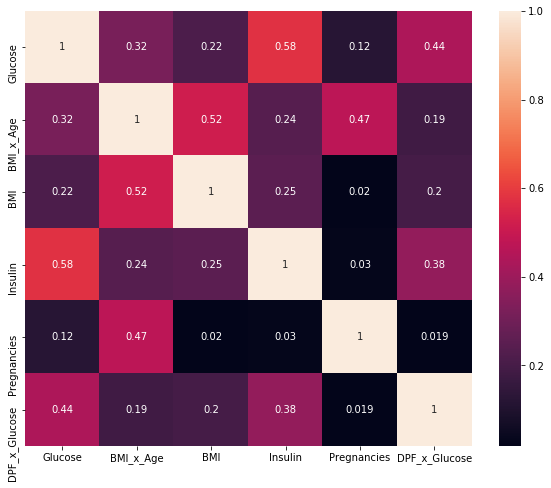

In [1031]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_selected.corr(), annot=True)
plt.show()

When performing cross validation now, it is quite clear that all the models perform better than they did before.

In [994]:
print("Cross validation:")
for i, model in enumerate(models):
    scores = cross_val_score(model, X_train_selected, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.770325848155
Naive Bayes :  0.752518777435
Random Forest :  0.771845670334
Extra Trees :  0.770352289192
XGBoost :  0.768686933829


### Hyperparameter Tuning

We can get some further improvements by tuning hyperparameters of a few of the models. By performing random search on the Random Forest, Extra Trees, and XGBoost models, we can figure out what hyperparameters lead to the best accuracy. 

In [1032]:
### Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 30)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 8)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Minimum loss reduction per node
gamma = [0, 0.5, 1, 1.5, 2, 5]


# Grid Parameters
rf_random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

xgb_random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma}


In [996]:
# Random Search for Random Forest
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), \
                               param_distributions = rf_random_grid, \
                               n_iter = 200, \
                               cv = k_folds)

rf_random.fit(X_train_selected, y_train)

rf_best_random = rf_random.best_estimator_

In [997]:
# Random Search for Extra Trees
et_random = RandomizedSearchCV(estimator = ExtraTreesClassifier(), \
                               param_distributions = rf_random_grid, \
                               n_iter = 200, \
                               cv = k_folds)

et_random.fit(X_train_selected, y_train)

et_best_random = et_random.best_estimator_

In [998]:
# Random Search for XGBoost
xgb_random = RandomizedSearchCV(estimator = XGBClassifier(), \
                               param_distributions = xgb_random_grid, \
                               n_iter = 200, \
                               cv = k_folds)

xgb_random.fit(X_train_selected, y_train)

xgb_best_random = xgb_random.best_estimator_

In [1009]:
models_best = [LogisticRegression(solver = 'liblinear'), GaussianNB(), \
          rf_best_random, et_best_random, xgb_best_random]

Through performing cross validation on the tuned models, we see that accuracy slightly improved for Random Forest, Extra Trees, and XGBoost.

In [1013]:
print("Cross validation:")
for i, model in enumerate(models_best):
    scores = cross_val_score(model, X_train_selected, y_train, cv=k_folds, scoring='accuracy')
    print(model_names[i], ": ", scores.mean())

Cross validation:
Logistic Regression :  0.770325848155
Naive Bayes :  0.752518777435
Random Forest :  0.780042176678
Extra Trees :  0.762221992923
XGBoost :  0.776869897202


### Run Test Set for Final Prediction

From performing cross validation with each model, we can see that the random forest model performed the best so we will use a this model on the test set for the final prediction.

In [1022]:
# Final Random Forest model for predictions 
print("Test Set:")
predictions = rf_best_random.fit(X_train_selected, y_train).predict(X_test_selected)
print("Accuracy: ", round(metrics.accuracy_score(y_test, predictions) * 100, 1), "%")

Test Set:
Accuracy:  79.9 %


Our final predictions resulted in approximately 80% accuracy. This is about 2% higher than our predictions with the basic model! 

At this point it is possible to try stacking the models and using majority vote, but resulting predictions will only be marginally different. So using the random forest model in this analysis is sufficient. 